# FashionMNIST

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

Мы будем работать с картинками одежды (чёрно-белыми, 28 на 28). По входной картинке нужно предсказать тип одежды на 10 классов.

In [ ]:
# установим последнюю версию wandb
!pip install -q --upgrade wandb

In [ ]:
import os
import wandb # для логирования

import numpy as np
import random
from tqdm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt

In [ ]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU
    #torch.backends.cudnn.deterministic = True # выбираем только детерминированные алгоритмы (для сверток)
    #torch.backends.cudnn.benchmark = False # фиксируем алгоритм вычисления сверток

Выпишем все классы для последующего использования.

In [ ]:
class CFG:

# Задаем параметры нашего эксперимента

  api = "b7aa62e0a99990c241c682743376c68b282c86755f"# вписать свой API Wandb
  project = "DL_Homework_AK-12"# вписать название эксперимента, который предварительно надо создать в Wandb
  entity = "alkud12"# ввести свой логин
  num_epochs = 10 # количество эпох
  train_batch_size = 64 # размер батча обучающей выборки
  test_batch_size = 512 # размер батча тестовой выборки
  num_workers = 4 # количество активных процессов на загрузку данных
  lr = 0.001 # learning_rate
  seed = 2022 # для функции воспроизводимости
  #classes = # ВАШ КОД ЗДЕСЬ # классы датасета
  wandb = False # флаг использования Wandb


In [ ]:
# функция перевода класса конфигурации в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

Обратим внимание, что датасет поменялся, а значит поменлись среднее и стандартное отклонение, их необходимо посмотреть на официальной страничке датасета [ссылка](https://boscoj2008.github.io/customCNN/).

In [ ]:
# будем загружать картинки, сразу преобразуя их в тензор и нормализуя

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

Загружаем данные.

In [ ]:
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG.train_batch_size,
                                          shuffle=True, num_workers=CFG.num_workers, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=CFG.test_batch_size,
                                         shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

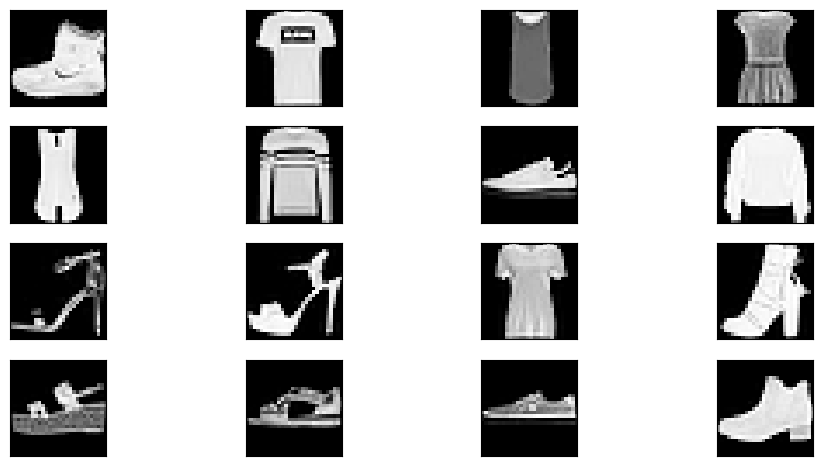

In [ ]:
# отрисуем несколько картинок

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(10, 5))
for idx in np.arange(16):
  plt.subplot(4,4,idx+1) # отрисуем 16 картинок
  plt.tight_layout()
  plt.imshow(train_data[idx][0].view(28, 28), cmap='Greys_r')
  plt.xticks([])
  plt.yticks([])

Создаем полносвязаннную нейронную сеть.

In [ ]:
class My_Net(nn.Module): # наследуемся от класса nn.Module

    def __init__(self):
        super().__init__()
        # количество нейронов в скрытых слоях (256, 128)
        hidden_1 = 256
        hidden_2 = 128
        # первый слой (784(=28*28) -> hidden_1)
        self.fc1 = nn.Linear(28*28, hidden_1)
        # второй слой (hidden_1 -> hidden_2)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        # третий (выходной) слой (hidden_2 -> 10 (классов))
        self.fc3 = nn.Linear(hidden_2, 10)

    def forward(self, x):
        # преобразуем батч картинок из (N, 1, 28, 28) в (N, 784)
        x = x.view(-1, 28*28)
        # добавляем первый скрытый слой с ReLU активацией
        x = F.relu(self.fc1(x))
        # добавляем второй скрытый слой с ReLU активацией
        x = F.relu(self.fc2(x))
        # добавляем третий (выходной) слой
        x = F.softmax(self.fc3(x), dim=1)
        return x

In [ ]:
model = My_Net()
model = model.to('cuda:0' if torch.cuda.is_available() else 'cpu') # переводим модель на GPU
print(model) # посмотрим на нашу модель

My_Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

# SGD (классический) со скоростью обучения (learning rate) = 0.01
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# функция обучения модели
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train() # обязательно переводим в режим обучения
    test_loss = 0
    correct = 0

    n_ex = len(train_loader)

    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device) # переводим картинки и таргеты на GPU
        # обнуляем градиенты!
        optimizer.zero_grad()
        # прямой проход
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # определяем корректность предсказания
        train_loss = criterion(output, target) # считаем значение функции потерь
        # обратный проход
        train_loss.backward()
        # делаем градиентный шаг оптимизатором
        optimizer.step()
        # считаем метрики и лосс
    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss, 100. * correct / len(train_loader.dataset)))

    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': correct / len(train_loader.dataset)})

In [ ]:
# функция тестирования
def test(model, device, test_loader, criterion, WANDB):
    model.eval() # переводем модель в режим инференса
    test_loss = 0
    correct = 0
    # показываем, что обученич нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target) # считаем значение функции потерь
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # считаем метрики
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))

    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [ ]:
# основная функция для экспериментов
def main(model):
    # настраиваем окружение для wandb
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))

    use_cuda = torch.cuda.is_available() # проверяем доступность GPU

    seed_everything(CFG.seed) # фиксируем сиды

    device = 'cuda:0' if use_cuda else 'cpu' # выделили устройство

    if CFG.wandb:
        wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)

    for epoch in range(1, CFG.num_epochs + 1): # цикл на эпохи
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is end!')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed Oct  4 14:29:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    26W /  70W |    839MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
main(model)


Epoch: 1


100%|██████████| 938/938 [00:16<00:00, 57.12it/s]


Train set: Average loss: 2.0290, Accuracy: 35%


Test set: Average loss: 1.9435, Accuracy: 58%

Epoch: 2


100%|██████████| 938/938 [00:22<00:00, 42.21it/s]


Train set: Average loss: 1.7589, Accuracy: 61%


Test set: Average loss: 1.8068, Accuracy: 67%

Epoch: 3


100%|██████████| 938/938 [00:15<00:00, 60.17it/s]


Train set: Average loss: 1.6643, Accuracy: 70%


Test set: Average loss: 1.7393, Accuracy: 71%

Epoch: 4


100%|██████████| 938/938 [00:14<00:00, 62.78it/s]


Train set: Average loss: 1.9511, Accuracy: 75%


Test set: Average loss: 1.6817, Accuracy: 77%

Epoch: 5


100%|██████████| 938/938 [00:14<00:00, 63.09it/s]


Train set: Average loss: 1.7600, Accuracy: 78%


Test set: Average loss: 1.6579, Accuracy: 78%

Epoch: 6


100%|██████████| 938/938 [00:15<00:00, 61.94it/s]


Train set: Average loss: 1.6399, Accuracy: 79%


Test set: Average loss: 1.6497, Accuracy: 79%

Epoch: 7


100%|██████████| 938/938 [00:15<00:00, 59.95it/s]


Train set: Average loss: 1.6519, Accuracy: 80%


Test set: Average loss: 1.6469, Accuracy: 79%

Epoch: 8


100%|██████████| 938/938 [00:15<00:00, 58.97it/s]


Train set: Average loss: 1.5995, Accuracy: 80%


Test set: Average loss: 1.6399, Accuracy: 79%

Epoch: 9


100%|██████████| 938/938 [00:15<00:00, 62.32it/s]


Train set: Average loss: 1.6466, Accuracy: 80%


Test set: Average loss: 1.6386, Accuracy: 80%

Epoch: 10


100%|██████████| 938/938 [00:15<00:00, 62.41it/s]


Train set: Average loss: 1.7112, Accuracy: 81%


Test set: Average loss: 1.6404, Accuracy: 80%
Training is end!


In [ ]:
# добавим 3 слоя
class My_Net(nn.Module):

    def __init__(self):
        super(My_Net, self).__init__()
        hidden_1 = 256
        hidden_2 = 128
        hidden_3 = 64
        hidden_4 = 32
        hidden_5 = 16
        self.fc1 = nn.Linear(28*28, hidden_1)
        self.fc2 = nn.Linear(hidden_1, hidden_2)
        self.fc3 = nn.Linear(hidden_2, hidden_3)
        self.fc4 = nn.Linear(hidden_3, hidden_4)
        self.fc5 = nn.Linear(hidden_4, hidden_5)
        self.fc6 = nn.Linear(hidden_5, 10)


    def forward(self,x):
        x = x.view(-1, 28*28)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = F.softmax(self.fc6(x), dim=1)
        return x

In [ ]:
# оптимизатор Adaptive Moment Estimation
optimizer = optim.Adam(model.parameters(), lr=1e-3)
main(model)


Epoch: 1


100%|██████████| 938/938 [00:15<00:00, 62.17it/s]


Train set: Average loss: 1.5910, Accuracy: 80%


Test set: Average loss: 1.6048, Accuracy: 82%

Epoch: 2


100%|██████████| 938/938 [00:15<00:00, 61.41it/s]


Train set: Average loss: 1.5857, Accuracy: 84%


Test set: Average loss: 1.5959, Accuracy: 83%

Epoch: 3


100%|██████████| 938/938 [00:15<00:00, 61.25it/s]


Train set: Average loss: 1.5236, Accuracy: 84%


Test set: Average loss: 1.5963, Accuracy: 82%

Epoch: 4


100%|██████████| 938/938 [00:15<00:00, 61.82it/s]


Train set: Average loss: 1.7408, Accuracy: 85%


Test set: Average loss: 1.6157, Accuracy: 82%

Epoch: 5


100%|██████████| 938/938 [00:14<00:00, 62.94it/s]


Train set: Average loss: 1.6704, Accuracy: 85%


Test set: Average loss: 1.5813, Accuracy: 84%

Epoch: 6


100%|██████████| 938/938 [00:15<00:00, 62.02it/s]


Train set: Average loss: 1.5237, Accuracy: 86%


Test set: Average loss: 1.5679, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:14<00:00, 62.59it/s]


Train set: Average loss: 1.5484, Accuracy: 86%


Test set: Average loss: 1.5855, Accuracy: 85%

Epoch: 8


100%|██████████| 938/938 [00:15<00:00, 61.62it/s]


Train set: Average loss: 1.5628, Accuracy: 86%


Test set: Average loss: 1.5756, Accuracy: 86%

Epoch: 9


100%|██████████| 938/938 [00:15<00:00, 61.99it/s]


Train set: Average loss: 1.5237, Accuracy: 86%


Test set: Average loss: 1.5913, Accuracy: 85%

Epoch: 10


100%|██████████| 938/938 [00:15<00:00, 62.45it/s]


Train set: Average loss: 1.6476, Accuracy: 87%


Test set: Average loss: 1.5756, Accuracy: 85%
Training is end!


In [ ]:
# оптимизатор Root Mean Square Propagation
optimizer = optim.RMSprop(model.parameters(), lr=1e-3)
main(model)


Epoch: 1


100%|██████████| 938/938 [00:14<00:00, 62.60it/s]


Train set: Average loss: 1.6404, Accuracy: 85%


Test set: Average loss: 1.6047, Accuracy: 84%

Epoch: 2


100%|██████████| 938/938 [00:15<00:00, 61.99it/s]


Train set: Average loss: 1.5548, Accuracy: 86%


Test set: Average loss: 1.5808, Accuracy: 85%

Epoch: 3


100%|██████████| 938/938 [00:14<00:00, 62.59it/s]


Train set: Average loss: 1.5237, Accuracy: 86%


Test set: Average loss: 1.5922, Accuracy: 84%

Epoch: 4


100%|██████████| 938/938 [00:16<00:00, 57.85it/s]


Train set: Average loss: 1.7564, Accuracy: 87%


Test set: Average loss: 1.6095, Accuracy: 81%

Epoch: 5


100%|██████████| 938/938 [00:15<00:00, 61.65it/s]


Train set: Average loss: 1.6466, Accuracy: 86%


Test set: Average loss: 1.6064, Accuracy: 85%

Epoch: 6


100%|██████████| 938/938 [00:15<00:00, 61.10it/s]


Train set: Average loss: 1.5237, Accuracy: 87%


Test set: Average loss: 1.5774, Accuracy: 85%

Epoch: 7


100%|██████████| 938/938 [00:15<00:00, 61.61it/s]


Train set: Average loss: 1.4924, Accuracy: 87%


Test set: Average loss: 1.6008, Accuracy: 83%

Epoch: 8


100%|██████████| 938/938 [00:15<00:00, 61.75it/s]


Train set: Average loss: 1.5860, Accuracy: 87%


Test set: Average loss: 1.5786, Accuracy: 86%

Epoch: 9


100%|██████████| 938/938 [00:17<00:00, 52.74it/s]


Train set: Average loss: 1.5862, Accuracy: 86%


Test set: Average loss: 1.5621, Accuracy: 86%

Epoch: 10


100%|██████████| 938/938 [00:15<00:00, 59.92it/s]


Train set: Average loss: 1.6174, Accuracy: 87%


Test set: Average loss: 1.5758, Accuracy: 85%
Training is end!
